In [77]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from dataclasses import dataclass
import utils
from torch_geometric_temporal import  DynamicGraphTemporalSignal,StaticGraphTemporalSignal, temporal_signal_split, DynamicGraphTemporalSignalBatch
import networkx as nx
from torch_geometric.utils import from_networkx
import scipy
import sklearn
from tqdm import tqdm
from torch_geometric.data import Data
from torch_geometric.loader import DynamicBatchSampler,DataLoader
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.ops import sigmoid_focal_loss
from torch_geometric_temporal.nn.recurrent import DCRNN,  GConvGRU, A3TGCN, TGCN2, TGCN, A3TGCN2
from torch_geometric_temporal.nn.attention import STConv
from torchmetrics.classification import BinaryRecall,BinarySpecificity, AUROC, ROC
from torch_geometric.nn import global_mean_pool
import timeit
import pytorch_lightning as pl
from torch_geometric.nn import GCNConv,BatchNorm,GATv2Conv
from sklearn.model_selection import KFold,StratifiedKFold
import mne_features
import torchaudio
import random
from mne_features.univariate import compute_kurtosis, compute_hjorth_complexity, compute_hjorth_mobility

In [2]:
torch.manual_seed(42)
random.seed(42)

In [3]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [56]:
# TODO think about using kwargs argument here to specify args for dataloader
@dataclass
class SeizureDataLoader:
    npy_dataset_path :Path
    event_tables_path : Path
    plv_values_path : Path
    loso_patient : str = None
    sampling_f : int = 256
    seizure_lookback: int = 600
    sample_timestep: int = 5
    inter_overlap: int = 0
    ictal_overlap: int = 0
    self_loops : bool = True
    balance : bool = True
    train_test_split:  float = None
    fft : bool = False
    hjorth : bool = False
    downsample : int = None
    buffer_time : int = 15
    """Class to prepare dataloaders for eeg seizure perdiction from stored files.

    Attributes:
        npy_dataset_path {Path} -- Path to folder with dataset preprocessed into .npy files.
        event_tables_path {Path} -- Path to folder with .csv files containing seizure events information for every patient.
        loso_patient {str} -- Name of patient to be selected for LOSO valdiation, specified in format "chb{patient_number}"",
        eg. "chb16". (default: {None}).
        samplin_f {int} -- Sampling frequency of the loaded eeg data. (default: {256}).
        seizure_lookback {int} -- Time horizon to sample pre-seizure data (length of period before seizure) in seconds. 
        (default: {600}).
        sample_timestep {int} -- Amounts of seconds analyzed in a single sample. (default: {5}).
        overlap {int} -- Amount of seconds overlap between samples. (default: {0}).
        self_loops {bool} -- Wheather to add self loops to nodes of the graph. (default: {True}).
        shuffle {bool} --  Wheather to shuffle training samples.


    """
    def _get_event_tables(self,patient_name : str) -> tuple[dict,dict]:
        """Read events for given patient into start and stop times lists from .csv extracted files."""

        event_table_list = os.listdir(self.event_tables_path)
        patient_event_tables = [os.path.join(self.event_tables_path,ev_table)
        for ev_table in event_table_list if patient_name in ev_table]
        patient_event_tables = sorted(patient_event_tables)
        patient_start_table = patient_event_tables[0] ## done terribly, but it has to be so for win/linux compat
        patient_stop_table = patient_event_tables[1]
        start_events_dict = pd.read_csv(patient_start_table).to_dict('index')
        stop_events_dict = pd.read_csv(patient_stop_table).to_dict('index')
        return start_events_dict,stop_events_dict
        
    def _get_recording_events(self,events_dict,recording) -> list[int]:
        """Read seizure times into list from event_dict"""
        recording_list = list(events_dict[recording+'.edf'].values())
        recording_events = [int(x) for x in recording_list if not np.isnan(x)]
        return recording_events


    def _get_graph(self,n_nodes: int) -> nx.Graph :
        """Creates Networx fully connected graph with self loops"""
        graph = nx.complete_graph(n_nodes)
        self_loops = [[node,node]for node in graph.nodes()]
        graph.add_edges_from(self_loops)
        return graph
    
    def _get_edge_weights_recording(self,plv_values: np.ndarray) ->np.ndarray:
        """Method that takes plv values for given recording and assigns them 
        as edge attributes to a fc graph."""
        graph = self._get_graph(plv_values.shape[0])
        garph_dict = {}
        for edge in graph.edges():
            e_start,e_end = edge
            garph_dict[edge] = {'plv':plv_values[e_start,e_end]}
        nx.set_edge_attributes(graph, garph_dict)
        edge_weights = from_networkx(graph).plv.numpy()
        return edge_weights
    
    def _get_edges(self):
        """Method to assign edge attributes. Has to be called AFTER get_dataset() method."""
        graph = self._get_graph(self._features.shape[1])
        edges = np.expand_dims(from_networkx(graph).edge_index.numpy(),axis=0)
        edges_per_sample_train = np.repeat(edges,repeats =self._features.shape[0],axis=0)
        self._edges = torch.tensor(edges_per_sample_train)
        if self.loso_patient is not None:
            edges_per_sample_val = np.repeat(edges,repeats =self._val_features.shape[0],axis=0)
            self._val_edges = torch.tensor(edges_per_sample_val)
       
    def _array_to_tensor(self):
        """Method converting features, edges and weights to torch.tensors"""
        self._features = torch.tensor(self._features,dtype=torch.float32)
        self._labels = torch.tensor(self._labels)
        self._time_labels = torch.tensor(self._time_labels)
        self._edge_weights = torch.tensor(self._edge_weights)
     
    
    def _val_array_to_tensor(self):
        self._val_features = torch.tensor(self._val_features,dtype=torch.float32)
        self._val_labels = torch.tensor(self._val_labels)
        self._val_time_labels = torch.tensor(self._val_time_labels)
        self._val_edge_weights = torch.tensor(self._val_edge_weights)
     
        
    def _get_labels_count(self):
        labels,counts = np.unique(self._labels,return_counts=True)
        self._label_counts = {}
        for n, label in enumerate(labels):
            self._label_counts[int(label)] = counts[n]
        
    def _get_val_labels_count(self):
        labels,counts = np.unique(self._val_labels,return_counts=True)
        self._val_label_counts = {}
        for n, label in enumerate(labels):
            self._val_label_counts[int(label)] = counts[n]
    
    def _perform_features_train_fft(self):
        self._features = torch.fft.fft(self._features)
    def _perform_features_val_fft(self):  
        self._val_features = torch.fft.fft(self._val_features)
    
    def _downsample_features_train(self):
        resampler = torchaudio.transforms.Resample(self.sampling_f,self.downsample)
        self._features = resampler(self._features)
        
    def _downsample_features_val(self):
        resampler = torchaudio.transforms.Resample(self.sampling_f,self.downsample)
        self._val_features = resampler(self._val_features)
    
    def _calculate_hjorth_features_train(self):
        
        new_features = [np.concatenate(
            [
                compute_hjorth_mobility(feature),
                compute_hjorth_complexity(feature),
            ], axis=1
        ) for feature in self._features
        ]
        self._features = np.array(new_features)
        
    def _calculate_hjorth_features_val(self):
        
        new_features = [np.concatenate(
            [
                compute_hjorth_mobility(feature),
                compute_hjorth_complexity(feature),
            ], axis=1
        ) for feature in self._val_features
        ]
        self._val_features = np.array(new_features)
        
    def _balance_classes(self):
        negative_label = self._label_counts[0]
        positive_label = self._label_counts[1]
    
        imbalance = negative_label - positive_label
        negative_indices = np.where(self._labels == 0)[0]
        indices_to_discard = np.random.choice(negative_indices,size = imbalance,replace=False)

        self._features = np.delete(self._features,obj=indices_to_discard,axis=0)
        self._labels = np.delete(self._labels,obj=indices_to_discard,axis=0)
        self._time_labels = np.delete(self._time_labels,obj=indices_to_discard,axis=0)
        self._edge_weights = np.delete(self._edge_weights,obj=indices_to_discard,axis=0)

        
    def _get_labels_features_edge_weights(self):
        """Prepare features, labels, time labels and edge wieghts for training and 
        optionally validation data."""
        patient_list = os.listdir(self.npy_dataset_path)
        for patient in patient_list: # iterate over patient names
            event_tables = self._get_event_tables(patient) # extract start and stop of seizure for patient 
            patient_path = os.path.join(self.npy_dataset_path,patient)
            recording_list = os.listdir(patient_path)
            for record in recording_list: # iterate over recordings for a patient
                recording_path = os.path.join(patient_path,record)
                record_id = record.split('.npy')[0] #  get record id
                start_event_tables = self._get_recording_events(event_tables[0],record_id) # get start events
                stop_event_tables = self._get_recording_events(event_tables[1],record_id) # get stop events
                data_array = np.load(recording_path) # load the recording

                plv_edge_weights = np.expand_dims(
                    self._get_edge_weights_recording(
                        np.load(os.path.join(self.plv_values_path,patient,record))
          
                ),
                axis = 0
                )

                ##TODO add a gateway to reject seizure periods shorter than lookback
                # extract timeseries and labels from the array
                features,labels,time_labels = utils.extract_training_data_and_labels(
                    data_array,
                    start_event_tables,
                    stop_event_tables,
                    fs = self.sampling_f,
                    seizure_lookback = self.seizure_lookback,
                    sample_timestep = self.sample_timestep,
                    inter_overlap = self.inter_overlap,
                    ictal_overlap = self.ictal_overlap,
                    buffer_time=self.buffer_time
                )
                
                if  features is None:
                    continue
                time_labels = np.expand_dims(time_labels.astype(np.int32),1)
                labels = labels.reshape((labels.shape[0],1)).astype(np.float32)
                """SCALING FEATURES INTO uV!!!"""
               # features = features*(10**6)
                """SCALING FEATURES INTO uV!!!"""
                if patient == self.loso_patient:
                    try:
                        self._val_features = np.concatenate((self._val_features, features))
                        self._val_labels = np.concatenate((self._val_labels, labels))
                        self._val_time_labels = np.concatenate((self._val_time_labels , time_labels))
                        self._val_edge_weights = np.concatenate((
                            self._val_edge_weights,
                            np.repeat(plv_edge_weights,features.shape[0],axis=0)
                            ))
                    except:
                        self._val_features = features
                        self._val_labels = labels
                        self._val_time_labels = time_labels
                        self._val_edge_weights = np.repeat(plv_edge_weights,features.shape[0],axis=0)
                else:
                    try:
                        self._features = np.concatenate((self._features, features))
                        self._labels = np.concatenate((self._labels, labels))
                        self._time_labels = np.concatenate((self._time_labels , time_labels))
                        self._edge_weights = np.concatenate((
                            self._edge_weights,
                            np.repeat(plv_edge_weights,features.shape[0],axis=0)
                        ))
                       
                    except:
                        print("Creating initial attributes")
                        self._features = features
                        self._labels = labels
                        self._time_labels = time_labels
                        self._edge_weights = np.repeat(plv_edge_weights,features.shape[0],axis=0)
                
        
    # TODO define a method to create edges and calculate plv to get weights
    def get_dataset(self) -> DynamicGraphTemporalSignal:

        """Creating graph data iterators. The iterator yelds dynamic, weighted and undirected graphs
        containing self loops. Every node represents one electrode in EEG. The graph is fully connected,
        edge weights are calculated for every EEG recording as PLV between channels (edge weight describes 
        the "strength" of connectivity between two channels in a recording). Node features are values of 
        channel voltages in time. Features are of shape [nodes,features,timesteps].

        Returns:
            train_dataset {DynamicGraphTemporalSignal} -- Training data iterator.
            valid_dataset {DynamicGraphTemporalSignal} -- Validation data iterator (only if loso_patient is
            specified in class constructor).
        """
        ### TODO rozkminić o co chodzi z tym całym time labels - na razie wartość liczbowa która tam wchodzi
        ### to shape atrybutu time_labels
        
        self._get_labels_features_edge_weights()
        self.train_features_min_max = [self._features.min(),self._features.max()]
        if self.balance:
            self._get_labels_count()
            self._balance_classes()
        self._get_edges()
        self._get_labels_count()
        
        
        
        if self.hjorth:
            self._calculate_hjorth_features_train()
        self._array_to_tensor()
        if self.downsample:
            self._downsample_features_train()
        if self.fft:
            self._perform_features_train_fft()
        train_dataset = torch.utils.data.TensorDataset(
        self._features, self._edges, self._edge_weights, self._labels,  self._time_labels
        )
        if self.train_test_split is not None:
            train_dataset, val_dataset = torch.utils.data.random_split(
                train_dataset,[1-self.train_test_split,self.train_test_split],
                generator=torch.Generator().manual_seed(42)
            )
            
            train_dataloader = torch.utils.data.DataLoader(
                train_dataset, batch_size = 16,shuffle = True,num_workers=2,pin_memory = True, prefetch_factor = 4,
                drop_last=False
            )
            
            val_dataloader = torch.utils.data.DataLoader(
                val_dataset, batch_size = 16,shuffle = False,num_workers=2,pin_memory = True, prefetch_factor = 4,
                drop_last=False
            )
            loaders = [train_dataloader,val_dataloader]
        else:
            train_dataloader = torch.utils.data.DataLoader(
                train_dataset, batch_size = 16,shuffle = True,num_workers=2,pin_memory = True, prefetch_factor = 4,
                drop_last=False
            )
            loaders = [train_dataloader]
        if self.loso_patient:
            self.val_features_min_max = [self._val_features.min(),self._val_features.max()]
            self._get_val_labels_count()
            self._calculate_hjorth_features_val()
            self._val_array_to_tensor()
            if self.downsample:
                self._downsample_features_val()
            if self.fft:
                self._perform_features_val_fft()
            loso_dataset = torch.utils.data.TensorDataset(
                self._val_features, self._val_edges, self._val_edge_weights, self._val_labels, self._val_time_labels
            )
            loso_dataloader = torch.utils.data.DataLoader(
                loso_dataset, batch_size = 16,shuffle = False,pin_memory = True,num_workers=2, prefetch_factor = 4,
                drop_last=False
            )
            return (*loaders,loso_dataloader)

        return (*loaders,)
        
                

        

In [95]:
class GATv2(torch.nn.Module):
    def __init__(self, timestep,sfreq, n_nodes=18,batch_size=32):
        super(GATv2, self).__init__()
        self.n_nodes = n_nodes
        self.out_features = 128
        self.recurrent_1 = GATv2Conv(sfreq*timestep,32,heads=6, add_self_loops=True,improved=False,edge_dim=1)

        self.fc1 = torch.nn.Linear(3456, 1024)
        self.fc2 = torch.nn.Linear(1024, 512)
        self.fc3 = torch.nn.Linear(512, 128)
        self.fc4 = torch.nn.Linear(128, 1)
        self.flatten = torch.nn.Flatten(start_dim=0)
        self.dropout = torch.nn.Dropout()
    def forward(self, x, edge_index,edge_weight):
        x = torch.squeeze(x)
        h = self.recurrent_1(x, edge_index=edge_index, edge_attr = edge_weight)
     
        h = torch.nn.BatchNorm1d(192)(h)
        h = F.leaky_relu(h)
        h = self.flatten(h)
      
        h = self.dropout(h)
        h = self.fc1(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc3(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc4(h)
        return h

In [70]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, timestep,sfreq, n_nodes=18,batch_size=32):
        super(RecurrentGCN, self).__init__()
        self.n_nodes = n_nodes
        self.out_features = 128
        self.recurrent_1 = GCNConv(sfreq*timestep,32, add_self_loops=True,improved=False)
        self.recurrent_2 = GCNConv(32,64,add_self_loops=True,improved=False)
        self.recurrent_3 = GCNConv(64,128,add_self_loops=True,improved=False)
        self.fc1 = torch.nn.Linear(n_nodes*128, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 1)
        self.flatten = torch.nn.Flatten(start_dim=0)
        self.dropout = torch.nn.Dropout()
    def forward(self, x, edge_index,edge_weight):
        x = torch.squeeze(x)
        h = self.recurrent_1(x, edge_index=edge_index, edge_weight = edge_weight)
        h = torch.nn.BatchNorm1d(32)(h)
        h = F.leaky_relu(h)
        h = self.recurrent_2(h, edge_index,edge_weight)
        h = torch.nn.BatchNorm1d(64)(h)
        h = F.leaky_relu(h)
        h = self.recurrent_3(h, edge_index,edge_weight)
        h = torch.nn.BatchNorm1d(128)(h)
        h = F.leaky_relu(h)
        h = self.flatten(h)
        
        h = self.dropout(h)
        h = self.fc1(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc3(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc4(h)
        return h

In [87]:
TIMESTEP = 10
INTER_OVERLAP = 0
ICTAL_OVERLAP = 5
SFREQ = 256

dataloader = SeizureDataLoader(
    npy_dataset_path=Path('data/npy_data'),
    event_tables_path=Path('data/event_tables'),
    plv_values_path=Path('data/plv_arrays'),
    loso_patient='chb16',
    sampling_f=SFREQ,
    seizure_lookback=600,
    sample_timestep= TIMESTEP,
    inter_overlap=INTER_OVERLAP,
    ictal_overlap=ICTAL_OVERLAP,
    self_loops=False,
    balance=False,
    train_test_split=0.2,
    fft=True,
    hjorth=False,
    downsample=60
    
    )
train_loader,val_dataloader,loso_loader=dataloader.get_dataset()
alpha = list(dataloader._label_counts.values())[0]/list(dataloader._label_counts.values())[1]


Creating initial attributes


In [52]:
dataloader._features.shape

torch.Size([10043, 18, 2])

In [ ]:
class MyDumbNLP(torch.nn.Module):
    def __init__(self):
        super(MyDumbNLP, self).__init__()
        self.fc1 = torch.nn.Linear(252,128)
        self.fc2 = torch.nn.Linear(128,1)
        self.dropout = torch.nn.Dropout()
    def forward(self,x):
        h = torch.tensor(mne_features.univariate.compute_teager_kaiser_energy(x)).float()
     
        h = self.fc1(h)
        h = F.relu(h,inplace=True)
        h = self.dropout(h)
        out = self.fc2(h)
        return out

In [ ]:
## TODO 

## 2. Think of time series augmentation techniques

## 4.Try to run the algorithm on list of patients shown in the articles.


In [ ]:
## kfold loop
from torch.utils.data import SubsetRandomSampler
k=5
splits=KFold(n_splits=k,shuffle=True,random_state=42)
# mean = dataloader._features.squeeze().mean(dim=0)
# std = dataloader._features.squeeze().std(dim=0)

for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(train_loader)))):
        device = torch.device("cpu")
        model = RecurrentGCN(TIMESTEP,SFREQ,batch_size=16).to(device)
        #pos_weight=torch.full([1], 1.1
        loss_fn =  nn.BCEWithLogitsLoss(pos_weight=torch.full([1], alpha))
       
        optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
        recall = BinaryRecall(threshold=0.5)
        auroc = AUROC(task="binary")
        
        roc = ROC('binary')
        model.train()
       # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)
        
        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader_fold = DataLoader(train_loader.dataset, batch_size=16, sampler=train_sampler,drop_last = False)
        test_loader_fold = DataLoader(train_loader.dataset, batch_size=16, sampler=test_sampler,drop_last = False)
        print(f'Fold {fold+1}')
        for epoch in tqdm(range(20)):

        
                epoch_loss = 0.0
                epoch_loss_valid = 0.0
                model.train()
                sample_counter = 0
                batch_counter = 0
                print(get_lr(optimizer))
                for time, batch in enumerate(train_loader_fold): 
                
                        x, edge_index, edge_attr,y = batch[0:4]
                        
                        signal_samples = x.shape[3]
                        x = 2 / signal_samples * torch.abs(x)
                        
                        x = x.squeeze()
                        x = (x-x.mean(dim=0))/x.std(dim=0)
                        # mean = torch.mean(x,dim=0)
                        # std = torch.std(x,dim=0)
                        #x = (x-mean)/std
                
                        y_hat =torch.stack(
                                [model(x=x[n], edge_index=edge_index[n], edge_weight=edge_attr[n]) 
                                for n in range(x.shape[0])])
                        ##loss
                
                        loss = loss_fn(y_hat,y)
                        
                        epoch_loss += loss
                        ## get preds & gorund truth
                        try:
                                preds = torch.cat([preds,y_hat],dim=0)
                                ground_truth = torch.cat([ground_truth,y],dim=0)
                        
                        except:
                                preds= y_hat
                                ground_truth = y
                                optimizer.zero_grad()
                                loss.backward()
                                optimizer.step()

                ## calculate acc

                train_auroc = auroc(preds,ground_truth)
                sensitivity = recall(preds,ground_truth)
                del preds, ground_truth
                print(f'Epoch: {epoch}',f'Epoch sensitivity: {sensitivity}', f'Epoch loss: {epoch_loss.detach().numpy()/time+1}')
                print(f'Epoch AUROC: {train_auroc} ')
                model.eval()
                with torch.no_grad():
                        for time_valid, batch_valid in enumerate(test_loader_fold):
                                x, edge_index, edge_attr,y_val = batch_valid[0:4]
                                signal_samples = x.shape[3]
                                x = 2 / signal_samples * torch.abs(x)
                                x = x.squeeze()
                                # mean = torch.mean(x,dim=0)
                                # std = torch.std(x,dim=0)
                                x = (x-x.mean(dim=0))/x.std(dim=0)
                                #x = (x-mean)/std
                                y_hat_val = torch.stack(
                                        [model(x=x[n], edge_index=edge_index[n], edge_weight=edge_attr[n]) 
                                        for n in range(x.shape[0])])
                                loss_valid = loss_fn(y_hat_val,y_val)

                                epoch_loss_valid += loss_valid
                                try:
                                        preds_valid = torch.cat([preds_valid,y_hat_val],dim=0)
                                        ground_truth_valid = torch.cat([ground_truth_valid,y_val],dim=0)
                                except:
                                        preds_valid= y_hat_val
                                        ground_truth_valid = y_val
               # scheduler.step(epoch_loss_valid)
                val_auroc = auroc(preds_valid,ground_truth_valid)
                val_sensitivity = recall(preds_valid,ground_truth_valid)
                del preds_valid, ground_truth_valid
                print(f'Epoch: {epoch}',f'Epoch val_sensitivity: {val_sensitivity}', f'Epoch val_loss: {epoch_loss_valid.detach().numpy()/time_valid+1}')
                print(f'Epoch val AUROC: {val_auroc} ')

In [ ]:
## dumb nlp loop
device = torch.device("cpu")
#model = RecurrentGCN(TIMESTEP,SFREQ,batch_size=16).to(device)
model = MyDumbNLP()
loss_fn =  nn.BCEWithLogitsLoss(pos_weight=torch.full([1], alpha))
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
recall = BinaryRecall(threshold=0.5,requires_grad=True)
auroc = AUROC(task="binary")
roc = ROC('binary')
model.train()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10)

for epoch in tqdm(range(20)):

    
        epoch_loss = 0.0
        epoch_loss_valid = 0.0
        model.train()
        sample_counter = 0
        batch_counter = 0
        print(get_lr(optimizer))
        for time, batch in enumerate(train_loader): ## TODO - this thing is still operating with no edge weights!!!
                ## find a way to compute plv per batch fast (is it even possible?)
        
                x, edge_index, edge_attr,y = batch[0:4]
                
                # signal_samples = x.shape[3]
                # x = 2 / signal_samples * torch.abs(x)
                
                x = x.squeeze()
                x = (x-x.mean(dim=0))/x.std(dim=0)
                # mean = torch.mean(x,dim=0)
                # std = torch.std(x,dim=0)
                #x = (x-mean)/std
           
                y_hat =torch.stack(
                        [model(x=x[n].float()) 
                         for n in range(x.shape[0])])
                ##loss
        
                loss = loss_fn(y_hat,y)
                
                ## get preds & gorund truth
                try:
                 preds = torch.cat([preds,y_hat],dim=0)
                 ground_truth = torch.cat([ground_truth,y],dim=0)
            
                except:
                 preds= y_hat
                 ground_truth = y
                
                epoch_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        ## calculate acc

        train_auroc = auroc(preds,ground_truth)
        sensitivity = recall(preds,ground_truth)
        del preds, ground_truth
        print(f'Epoch: {epoch}',f'Epoch sensitivity: {sensitivity}', f'Epoch loss: {epoch_loss.detach().numpy()/time+1}')
        print(f'Epoch AUROC: {train_auroc} ')
        model.eval()
        with torch.no_grad():
                for time_valid, batch_valid in enumerate(val_dataloader):
                        x, edge_index, edge_attr,y_val = batch_valid[0:4]
                        #signal_samples = x.shape[3]
                        # x = 2 / signal_samples * torch.abs(x)
                        x = x.squeeze()
                        # mean = torch.mean(x,dim=0)
                        # std = torch.std(x,dim=0)
                        x = (x-x.mean(dim=0))/x.std(dim=0)
                        #x = (x-mean)/std
                        y_hat_val = torch.stack(
                                [model(x=x[n].float()) 
                                 for n in range(x.shape[0])])
                        loss_valid = loss_fn(y_hat_val,y_val)

                        epoch_loss_valid += loss_valid
                        try:
                         preds_valid = torch.cat([preds_valid,y_hat_val],dim=0)
                         ground_truth_valid = torch.cat([ground_truth_valid,y_val],dim=0)
                        except:
                         preds_valid= y_hat_val
                         ground_truth_valid = y_val
        scheduler.step()
        val_auroc = auroc(preds_valid,ground_truth_valid)
        val_sensitivity = recall(preds_valid,ground_truth_valid)
        del preds_valid, ground_truth_valid
        print(f'Epoch: {epoch}',f'Epoch val_sensitivity: {val_sensitivity}', f'Epoch val_loss: {epoch_loss_valid.detach().numpy()/time_valid+1}')
        print(f'Epoch val AUROC: {val_auroc} ')

In [ ]:
model.eval()
loss_valid = 0.0
with torch.no_grad():
        for time_valid, batch_valid in enumerate(loso_dataloader):
                x, edge_index, edge_attr,y_val = batch_valid[0:4]
                #signal_samples = x.shape[3]
                # x = 2 / signal_samples * torch.abs(x)
                x = x.squeeze()
                # mean = torch.mean(x,dim=0)
                # std = torch.std(x,dim=0)
                x = (x-x.mean(dim=0))/x.std(dim=0)
                #x = (x-mean)/std
                y_hat_val = torch.stack(
                        [model(x=x[n].float()) 
                                for n in range(x.shape[0])])
                loss_valid = loss_fn(y_hat_val,y_val)

                epoch_loss_valid += loss_valid
                try:
                        preds_valid = torch.cat([preds_valid,y_hat_val],dim=0)
                        ground_truth_valid = torch.cat([ground_truth_valid,y_val],dim=0)
                except:
                        preds_valid= y_hat_val
                        ground_truth_valid = y_val

val_auroc = auroc(preds_valid,ground_truth_valid)
val_sensitivity = recall(preds_valid,ground_truth_valid)
del preds_valid, ground_truth_valid
print(f'Epoch: {epoch}',f'Epoch val_sensitivity: {val_sensitivity}', f'Epoch val_loss: {epoch_loss_valid.detach().numpy()/time_valid+1}')
print(f'Epoch val AUROC: {val_auroc} ')

In [25]:
import torchvision

In [1]:
## normal loop

device = torch.device("cpu")
model = GATv2(TIMESTEP,60,batch_size=16).to(device)
#pos_weight=torch.full([1], 1.1
loss_fn =  nn.BCEWithLogitsLoss(pos_weight=torch.full([1], alpha))

optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
resampler = torchaudio.transforms.Resample(256,60)
recall = BinaryRecall(threshold=0.5)
specificity = BinarySpecificity(threshold=0.6)
auroc = AUROC(task="binary")
roc = ROC('binary')
model.train()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)

for epoch in tqdm(range(13)):

    
        epoch_loss = 0.0
        epoch_loss_valid = 0.0
        model.train()
        sample_counter = 0
        batch_counter = 0
        print(get_lr(optimizer))
        for time, batch in enumerate(train_loader): ## TODO - this thing is still operating with no edge weights!!!
                ## find a way to compute plv per batch fast (is it even possible?)
        
                x, edge_index, edge_attr,y = batch[0:4]
               
                signal_samples = x.shape[3]
                x = 2 / signal_samples * torch.abs(x)
            
                x = x.squeeze()
                x = (x-x.mean(dim=0))/x.std(dim=0)
           
                y_hat =torch.stack(
                        [model(x=x[n], edge_index=edge_index[n], edge_weight=edge_attr[n].float()) 
                         for n in range(x.shape[0])])
                ##loss
        
                loss = loss_fn(y_hat,y)
                #loss = torchvision.ops.sigmoid_focal_loss(y_hat,y,alpha=alpha*0.1,gamma=2,reduction='mean')
                epoch_loss += loss
                ## get preds & gorund truth
                try:
                 preds = torch.cat([preds,y_hat],dim=0)
                 ground_truth = torch.cat([ground_truth,y],dim=0)
            
                except:
                 preds= y_hat.detach()
                 ground_truth = y
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        ## calculate acc

        train_auroc = auroc(preds,ground_truth)
        sensitivity = recall(preds,ground_truth)
        train_specificity = specificity(preds,ground_truth)
        del preds, ground_truth
        print(f'Epoch: {epoch}',f'Epoch sensitivity: {sensitivity}', f'Epoch loss: {epoch_loss.detach().numpy()/time+1}')
        print(f'Epoch specificity: {train_specificity}')
        print(f'Epoch AUROC: {train_auroc} ')
        model.eval()
        with torch.no_grad():
                for time_valid, batch_valid in enumerate(val_dataloader):
                        x, edge_index, edge_attr,y_val = batch_valid[0:4]
                    
                        signal_samples = x.shape[3]
                        x = 2 / signal_samples * torch.abs(x)
              
                        x = x.squeeze()
                      
                        x = (x-x.mean(dim=0))/x.std(dim=0)
                        
                        y_hat_val = torch.stack(
                                [model(x=x[n], edge_index=edge_index[n], edge_weight=edge_attr[n].float()) 
                                 for n in range(x.shape[0])])
                        loss_valid = loss_fn(y_hat_val,y_val)
                        #loss_valid = torchvision.ops.sigmoid_focal_loss(y_hat,y,alpha=alpha*0.1,gamma=2,reduction='mean')
                        epoch_loss_valid += loss_valid
                        try:
                         preds_valid = torch.cat([preds_valid,y_hat_val],dim=0)
                         ground_truth_valid = torch.cat([ground_truth_valid,y_val],dim=0)
                        except:
                         preds_valid= y_hat_val
                         ground_truth_valid = y_val
        scheduler.step(epoch_loss_valid)
        val_auroc = auroc(preds_valid,ground_truth_valid)
        val_sensitivity = recall(preds_valid,ground_truth_valid)
        val_specificity = specificity(preds_valid,ground_truth_valid)
        del preds_valid, ground_truth_valid
        print(f'Epoch: {epoch}',f'Epoch val_sensitivity: {val_sensitivity}', f'Epoch val_loss: {epoch_loss_valid.detach().numpy()/time_valid+1}')
        print(f'Epoch val specificity: {train_specificity}')
        print(f'Epoch val AUROC: {val_specificity} ')

NameError: name 'torch' is not defined

In [83]:
model.eval()

try:
        del preds_test,ground_truth_test
except:
        pass
loss_test_total = 0.0
with torch.no_grad():
        for time_test, batch_test in enumerate(loso_loader):
                x, edge_index, edge_attr,y_test = batch_test[0:4]
                signal_samples = x.shape[3]
                x = 2 / signal_samples * torch.abs(x)
                
                x = x.squeeze()
                x = (x-x.mean(dim=0))/x.std(dim=0)
                y_hat_test = torch.stack(
                                [model(x=x[n].float(), edge_index=edge_index[n], edge_weight=edge_attr[n].float()) 
                                        for n in range(x.shape[0])])
                loss_test = loss_fn(y_hat_test,y_test)
                loss_test_total+= loss_test
                try:
                 preds_test  = torch.cat([preds_test,y_hat_test],dim=0)
                 ground_truth_test = torch.cat([ground_truth_test,y_test],dim=0)
                except:
                 preds_test = y_hat_test
                 ground_truth_test = y_test
test_auroc = auroc(preds_test,ground_truth_test)
test_sensitivity = recall(preds_test,ground_truth_test)
print(f'Test sensitivity: {test_sensitivity}', f'Test loss: {loss_test_total.numpy()/time_test+1}')
print(f'Test AUROC: {test_auroc} ')

IndexError: tuple index out of range

In [16]:
x[12].shape

torch.Size([18, 600])

In [14]:
ground_truth_test

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])

In [13]:
nn.Sigmoid()(preds_test)

tensor([[2.1737e-02],
        [2.8777e-03],
        [2.3858e-01],
        [3.5076e-03],
        [1.0364e-02],
        [4.7990e-01],
        [2.4076e-01],
        [6.4314e-01],
        [1.1202e-04],
        [1.9877e-02],
        [6.6054e-03],
        [7.3178e-03],
        [2.3780e-04],
        [1.9216e-02],
        [1.4167e-03],
        [4.1621e-02],
        [7.1588e-02],
        [1.2937e-01],
        [1.8439e-02],
        [4.4233e-05],
        [2.3641e-03],
        [3.6222e-02],
        [2.2595e-03],
        [1.5049e-07],
        [2.0636e-01],
        [5.0370e-04],
        [1.5404e-01],
        [9.3539e-01],
        [8.2671e-01],
        [7.4010e-01],
        [1.6278e-02],
        [4.0697e-01],
        [3.0493e-02],
        [1.4850e-04],
        [1.3387e-01],
        [4.2417e-01],
        [3.8312e-02],
        [1.6792e-04],
        [5.2351e-04],
        [8.8920e-02],
        [5.6934e-02],
        [6.3590e-02],
        [1.6345e-02],
        [1.5481e-01],
        [4.0328e-04],
        [1

In [21]:
fpr, tpr, thresholds = roc(preds_test,ground_truth_test)

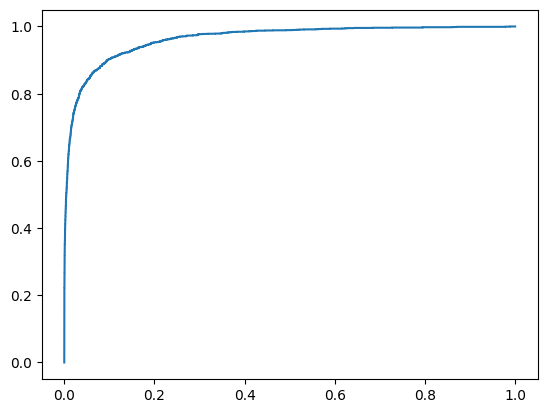

In [22]:
from matplotlib import pyplot as plt
plt.plot(fpr,tpr)

In [ ]:
np.equal(np.where(np.array(ground_truth) == 1)[0],np.where(np.array(preds) >0)[0] )

In [15]:
class TGCNBatched(torch.nn.Module):
    def __init__(self, timestep,sfreq, n_nodes=18,batch_size=32):
        super(TGCNBatched, self).__init__()
        self.n_nodes = n_nodes
        self.out_features = 128
        self.recurrent_1 = TGCN2(sfreq*timestep,32, add_self_loops=True,improved=False, batch_size=batch_size)
        self.recurrent_2 = TGCN2(32,64,add_self_loops=True,improved=False, batch_size=batch_size)
        self.recurrent_3 = TGCN2(64,128,add_self_loops=True,improved=False, batch_size=batch_size)
        self.fc1 = torch.nn.Linear(n_nodes*128, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, 1)
        self.flatten = torch.nn.Flatten(start_dim=1)
        self.dropout = torch.nn.Dropout()
    def forward(self, x, edge_index):
        x = torch.squeeze(x)
        h = self.recurrent_1(x, edge_index=edge_index)
        h = torch.nn.BatchNorm1d(18)(h)
        h = F.leaky_relu(h)
        h = self.recurrent_2(h, edge_index)
        h = torch.nn.BatchNorm1d(18)(h)
        h = F.leaky_relu(h)
        h = self.recurrent_3(h, edge_index)
        h = torch.nn.BatchNorm1d(18)(h)
      
        h = F.leaky_relu(h)
        h = self.flatten(h)
        h = self.dropout(h)
        h = self.fc1(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc2(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc3(h)
        h = F.leaky_relu(h)
        h = self.dropout(h)
        h = self.fc4(h)
        return h

In [16]:
## normal loop
device = torch.device("cpu")
model = TGCNBatched(TIMESTEP,60,batch_size=16).to(device)
#pos_weight=torch.full([1], 1.1
loss_fn =  nn.BCEWithLogitsLoss(pos_weight=torch.full([1], alpha))
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
recall = BinaryRecall(threshold=0.5)
auroc = AUROC(task="binary")
roc = ROC('binary')
resampler = torchaudio.transforms.Resample(256,60)
model.train()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',patience=2)

for epoch in tqdm(range(10)):

    
        epoch_loss = 0.0
        epoch_loss_valid = 0.0
        model.train()
        sample_counter = 0
        batch_counter = 0
        print(get_lr(optimizer))
        for time, batch in enumerate(train_loader): ## TODO - this thing is still operating with no edge weights!!!
                ## find a way to compute plv per batch fast (is it even possible?)
        
                x, edge_index, edge_attr,y = batch[0:4]
                
                # signal_samples = x.shape[3]
                # x = 2 / signal_samples * torch.abs(x)
                
                x = x.squeeze()
                x = (x-x.mean(dim=0))/x.std(dim=0)
           
                y_hat = model(x,edge_index[0])
                ##loss
        
                loss = loss_fn(y_hat,y)
                
                epoch_loss += loss
                ## get preds & gorund truth
                try:
                 preds = torch.cat([preds,y_hat],dim=0)
                 ground_truth = torch.cat([ground_truth,y],dim=0)
            
                except:
                 preds= y_hat
                 ground_truth = y
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        ## calculate acc

        train_auroc = auroc(preds,ground_truth)
        sensitivity = recall(preds,ground_truth)
        del preds, ground_truth
        print(f'Epoch: {epoch}',f'Epoch sensitivity: {sensitivity}', f'Epoch loss: {epoch_loss.detach().numpy()/time+1}')
        print(f'Epoch AUROC: {train_auroc} ')
        model.eval()
        with torch.no_grad():
                for time_valid, batch_valid in enumerate(val_dataloader):
                        x, edge_index, edge_attr,y_val = batch_valid[0:4]
                        
                        # signal_samples = x.shape[3]
                        # x = 2 / signal_samples * torch.abs(x)
                        x = x.squeeze()
                      
                        x = (x-x.mean(dim=0))/x.std(dim=0)
                     
                        y_hat_val = model(x.float(),edge_index[0])
                        loss_valid = loss_fn(y_hat_val,y_val)

                        epoch_loss_valid += loss_valid
                        try:
                         preds_valid = torch.cat([preds_valid,y_hat_val],dim=0)
                         ground_truth_valid = torch.cat([ground_truth_valid,y_val],dim=0)
                        except:
                         preds_valid= y_hat_val
                         ground_truth_valid = y_val
        scheduler.step(epoch_loss_valid)
        val_auroc = auroc(preds_valid,ground_truth_valid)
        val_sensitivity = recall(preds_valid,ground_truth_valid)
        del preds_valid, ground_truth_valid
        print(f'Epoch: {epoch}',f'Epoch val_sensitivity: {val_sensitivity}', f'Epoch val_loss: {epoch_loss_valid.detach().numpy()/time_valid+1}')
        print(f'Epoch val AUROC: {val_auroc} ')

  0%|          | 0/10 [00:00<?, ?it/s]

0.001
Epoch: 0 Epoch sensitivity: 0.6780905723571777 Epoch loss: 2.2557904368852713
Epoch AUROC: 0.5408072471618652 


 10%|█         | 1/10 [00:15<02:15, 15.05s/it]

Epoch: 0 Epoch val_sensitivity: 0.6763284802436829 Epoch val_loss: 2.2348775634765623
Epoch val AUROC: 0.6916943192481995 
0.001
Epoch: 1 Epoch sensitivity: 0.6070991158485413 Epoch loss: 2.1710371648172933
Epoch AUROC: 0.665611743927002 


 20%|██        | 2/10 [00:31<02:08, 16.03s/it]

Epoch: 1 Epoch val_sensitivity: 0.4057970941066742 Epoch val_loss: 2.160444580078125
Epoch val AUROC: 0.6969209909439087 
0.001
Epoch: 2 Epoch sensitivity: 0.6083231568336487 Epoch loss: 2.1272257162755226
Epoch AUROC: 0.7110415697097778 


 30%|███       | 3/10 [00:50<01:59, 17.07s/it]

Epoch: 2 Epoch val_sensitivity: 0.4589371979236603 Epoch val_loss: 2.140898681640625
Epoch val AUROC: 0.6977068185806274 
0.001
Epoch: 3 Epoch sensitivity: 0.5813953280448914 Epoch loss: 2.0961814363639193
Epoch AUROC: 0.7263129949569702 


 40%|████      | 4/10 [01:09<01:49, 18.17s/it]

Epoch: 3 Epoch val_sensitivity: 0.4975845515727997 Epoch val_loss: 2.11329443359375
Epoch val AUROC: 0.7286343574523926 
0.001
Epoch: 4 Epoch sensitivity: 0.509179949760437 Epoch loss: 2.071815277950697
Epoch AUROC: 0.7231451272964478 


 50%|█████     | 5/10 [01:28<01:32, 18.42s/it]

Epoch: 4 Epoch val_sensitivity: 0.3864734172821045 Epoch val_loss: 2.104787963867188
Epoch val AUROC: 0.7072305679321289 
0.001
Epoch: 5 Epoch sensitivity: 0.4773561954498291 Epoch loss: 2.046755847702938
Epoch AUROC: 0.7299982905387878 


 60%|██████    | 6/10 [01:47<01:14, 18.53s/it]

Epoch: 5 Epoch val_sensitivity: 0.3478260934352875 Epoch val_loss: 2.124690185546875
Epoch val AUROC: 0.7074652910232544 
0.001
Epoch: 6 Epoch sensitivity: 0.4993880093097687 Epoch loss: 2.0450905119755354
Epoch AUROC: 0.7378701567649841 


 70%|███████   | 7/10 [02:06<00:55, 18.51s/it]

Epoch: 6 Epoch val_sensitivity: 0.30917873978614807 Epoch val_loss: 2.1198828125
Epoch val AUROC: 0.7151045799255371 
0.001
Epoch: 7 Epoch sensitivity: 0.5140758752822876 Epoch loss: 2.0455662700759465
Epoch AUROC: 0.7451328635215759 


 80%|████████  | 8/10 [02:25<00:37, 18.69s/it]

Epoch: 7 Epoch val_sensitivity: 0.3913043439388275 Epoch val_loss: 2.1271722412109373
Epoch val AUROC: 0.6949011087417603 
0.0001
Epoch: 8 Epoch sensitivity: 0.5299877524375916 Epoch loss: 2.009807449887948
Epoch AUROC: 0.7493698596954346 


 90%|█████████ | 9/10 [02:44<00:18, 18.98s/it]

Epoch: 8 Epoch val_sensitivity: 0.40096619725227356 Epoch val_loss: 2.1264189453125
Epoch val AUROC: 0.7010490894317627 
0.0001
Epoch: 9 Epoch sensitivity: 0.5495715737342834 Epoch loss: 1.9862154166536978
Epoch AUROC: 0.764013946056366 


100%|██████████| 10/10 [03:04<00:00, 18.44s/it]

Epoch: 9 Epoch val_sensitivity: 0.4057970941066742 Epoch val_loss: 2.1267490234375
Epoch val AUROC: 0.704300045967102 


In [ ]:
mylayer = A3TGCN2(10*60,32,1,batch_size=16)

In [ ]:
mylayer(x,edge_index[0])

In [ ]:
x.shape

In [17]:
model.eval()
try:
        del preds_test,ground_truth_test
except:
        pass
loss_test_total = 0.0
with torch.no_grad():
        for time_test, batch_test in enumerate(val_dataloader):
                x, edge_index, edge_attr,y_test = batch_test[0:4]
                # signal_samples = x.shape[3]
                # x = 2 / signal_samples * torch.abs(x)
               
                x = x.squeeze()
                x = (x-x.mean(dim=0))/x.std(dim=0)
                y_hat_test = model(x.float(),edge_index[0])
                loss_test = loss_fn(y_hat_test,y_test)
                loss_test_total+= loss_test
                try:
                 preds_test  = torch.cat([preds_test,y_hat_test],dim=0)
                 ground_truth_test = torch.cat([ground_truth_test,y_test],dim=0)
                except:
                 preds_test = y_hat_test
                 ground_truth_test = y_test
test_auroc = auroc(preds_test,ground_truth_test)
test_sensitivity = recall(preds_test,ground_truth_test)
print(f'Test sensitivity: {test_sensitivity}', f'Test loss: {loss_test_total.numpy()/time_test+1}')
print(f'Epoch val AUROC: {test_auroc} ')

Test sensitivity: 0.4057970941066742 Test loss: 2.1267490234375
Epoch val AUROC: 0.704300045967102 


In [63]:
print(ground_truth_test)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.]])


In [60]:
dataloader._val_label_counts

{0: 60, 1: 1}

In [61]:
np.unique(preds_test.numpy(),return_counts=True)

(array([-14.716414, -14.44849 , -14.086151, ...,  11.199499,  11.632316,
         12.473233], dtype=float32),
 array([1, 1, 1, ..., 1, 1, 1]))